In [1]:
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib.pyplot as plt
import warnings
import json
from tqdm import tqdm
from googletrans import Translator
import numpy as np
import os


warnings.filterwarnings("ignore")

In [2]:
mono_train_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl"
mono_val_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl"
mono_train_addon_path = "./augmentation_data/mono_oversampling_addon.jsonl"
multi_train_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_train_multilingual.jsonl"
multi_val_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_dev_multilingual.jsonl"
multi_train_addon_path = "./augmentation_data/multi_oversampling_addon.jsonl"

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    return device

device = get_device()

In [4]:
def read_jsonl(path):
    data = []
    with open(path, "r") as f:
        for line in f:
            json_data = json.loads(line)
            data.append(json_data)
    return data


def get_pandas_dfs(train_path, val_path, train_sample=None, val_sample=None):
    train_data = read_jsonl(train_path)
    val_data = read_jsonl(val_path)
    
    train_df = pd.DataFrame(train_data).loc[:, ["text", "label", "source"]]
    train_df["label"] = train_df["label"].map(lambda x: "LLM" if x==1 else "human")
    val_df = pd.DataFrame(val_data).loc[:, ["text", "label", "source"]]
    val_df["label"] = val_df["label"].map(lambda x: "LLM" if x==1 else "human")
    
    if train_sample:
        train_df = train_df.sample(n=train_sample, random_state=42).reset_index(drop=True)
    if val_sample:
        val_df = val_df.sample(n=val_sample, random_state=42).reset_index(drop=True)
    
    return train_df, val_df


def get_pandas_atomic_dfs(data_path):
    all_data = read_jsonl(data_path)
    
    data_df = pd.DataFrame(all_data).loc[:, ["text", "label", "source"]]
    
    return data_df


mono_train_df, mono_val_df = get_pandas_dfs(train_path=mono_train_path, val_path=mono_val_path)
multi_train_df, multi_val_df = get_pandas_dfs(train_path=multi_train_path, val_path=multi_val_path)

mono_train_addon_df = get_pandas_atomic_dfs(mono_train_addon_path)
multi_train_addon_df = get_pandas_atomic_dfs(multi_train_addon_path)

In [5]:
mono_train_df = pd.concat([mono_train_df, mono_train_addon_df], axis=0, ignore_index=True)
multi_train_df = pd.concat([multi_train_df, multi_train_addon_df], axis=0, ignore_index=True)

In [6]:
print(mono_train_df.head())

                                                text label   source
0  Forza Motorsport is a popular racing game that...   LLM  wikihow
1  Buying Virtual Console games for your Nintendo...   LLM  wikihow
2  Windows NT 4.0 was a popular operating system ...   LLM  wikihow
3  How to Make Perfume\n\nPerfume is a great way ...   LLM  wikihow
4  How to Convert Song Lyrics to a Song'\n\nConve...   LLM  wikihow


In [7]:
print(multi_train_df.head())

                                                text label   source
0  Forza Motorsport is a popular racing game that...   LLM  wikihow
1  Buying Virtual Console games for your Nintendo...   LLM  wikihow
2  Windows NT 4.0 was a popular operating system ...   LLM  wikihow
3  How to Make Perfume\n\nPerfume is a great way ...   LLM  wikihow
4  How to Convert Song Lyrics to a Song'\n\nConve...   LLM  wikihow


In [8]:
print(mono_train_df.shape)

(155000, 3)


In [9]:
print(multi_train_df.shape)

(288000, 3)


# Imbalance Analysis

# 1) Monolingual task -> Training

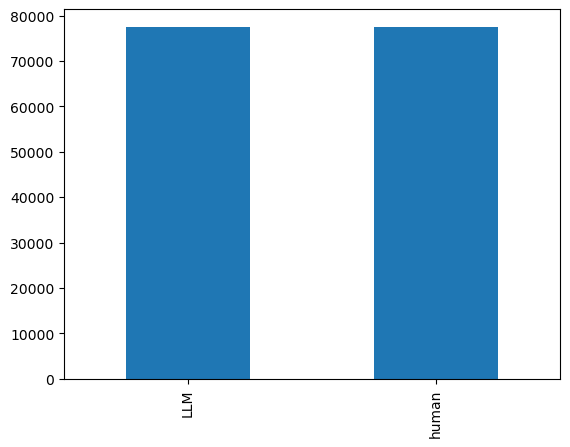

In [10]:
mono_train_df["label"].value_counts().plot.bar()
plt.show()

In [11]:
print(mono_train_df["source"].unique())

['wikihow' 'wikipedia' 'reddit' 'arxiv' 'peerread']


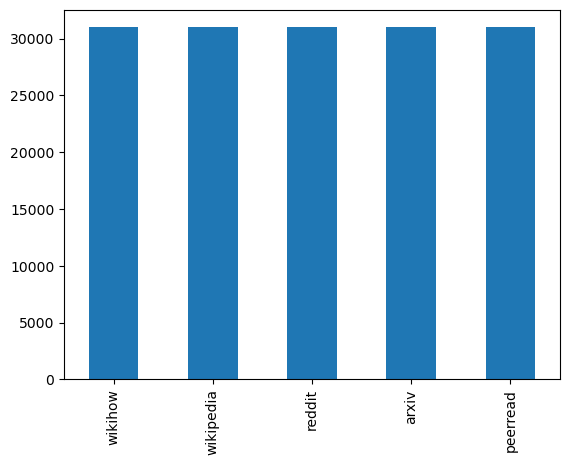

In [12]:
mono_train_df["source"].value_counts().plot.bar()
plt.show()

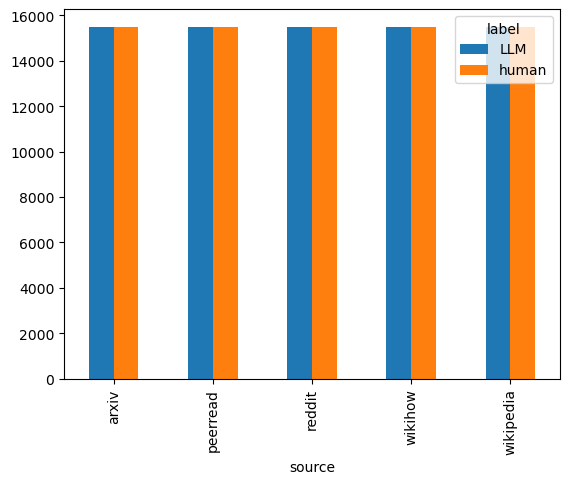

In [13]:
mono_train_df.groupby(['source', 'label']).size().unstack(fill_value=0).plot.bar()
plt.show()

# 2) Monolingual task -> Validation

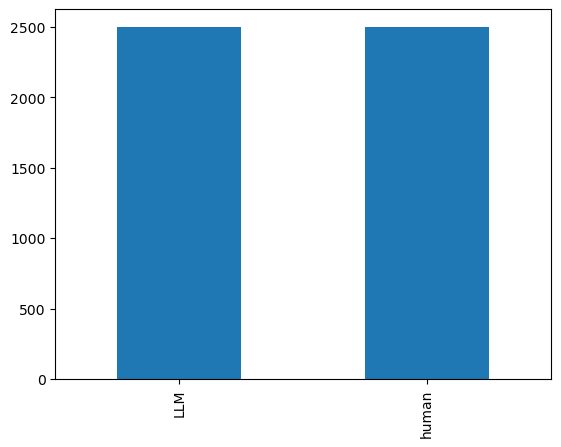

In [14]:
mono_val_df["label"].value_counts().plot.bar()
plt.show()

In [15]:
print(mono_val_df["source"].unique())

['wikihow' 'wikipedia' 'reddit' 'arxiv' 'peerread']


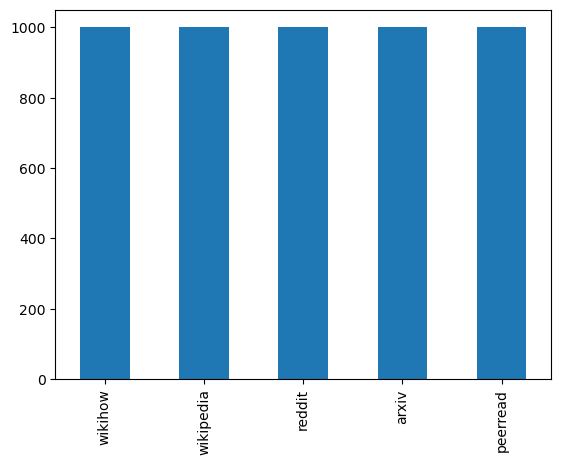

In [16]:
mono_val_df["source"].value_counts().plot.bar()
plt.show()

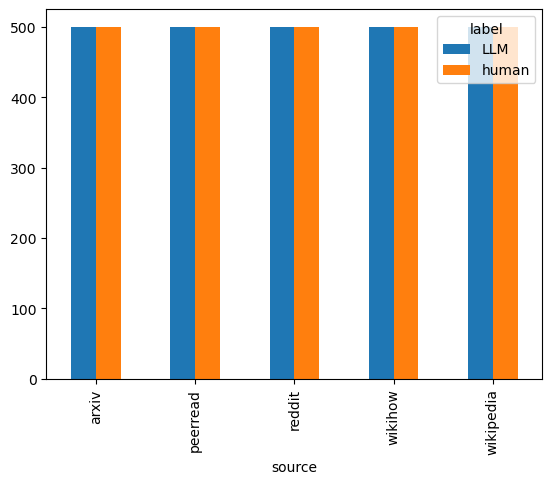

In [17]:
mono_val_df.groupby(['source', 'label']).size().unstack(fill_value=0).plot.bar()
plt.show()

# 3) Multilingual task -> Training

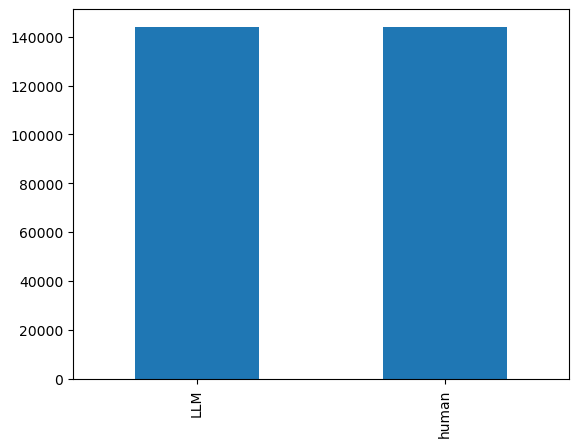

In [18]:
multi_train_df["label"].value_counts().plot.bar()
plt.show()

In [19]:
print(multi_train_df["source"].unique())

['wikihow' 'wikipedia' 'reddit' 'arxiv' 'bulgarian' 'urdu' 'indonesian'
 'chinese' 'peerread']


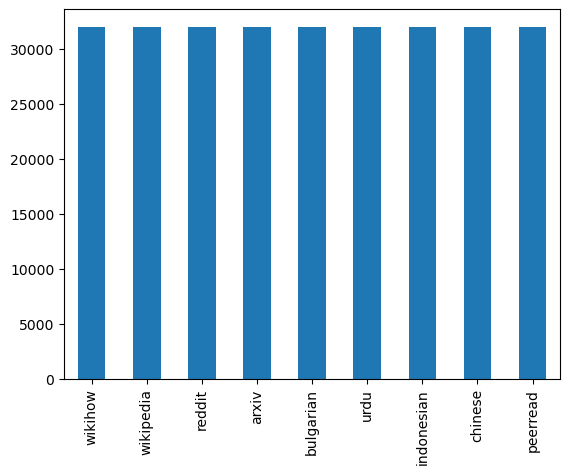

In [20]:
multi_train_df["source"].value_counts().plot.bar()
plt.show()

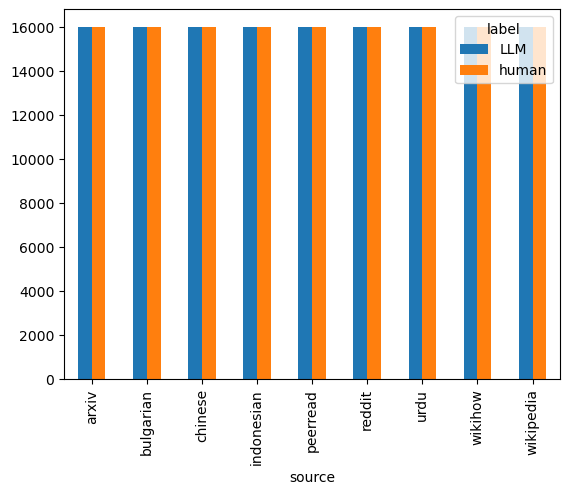

In [21]:
multi_train_df.groupby(['source', 'label']).size().unstack(fill_value=0).plot.bar()
plt.show()

# 4) Multilingual task -> Validation

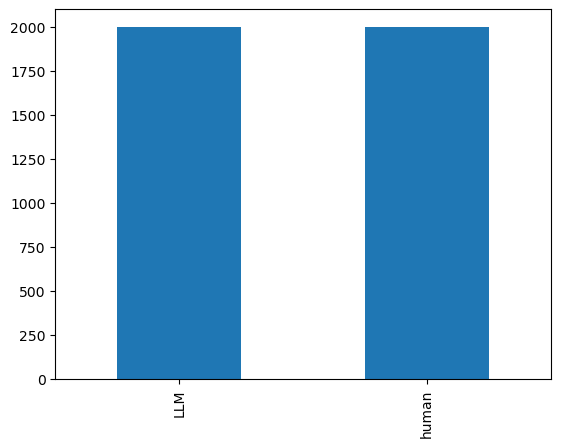

In [22]:
multi_val_df["label"].value_counts().plot.bar()
plt.show()

In [23]:
print(multi_val_df["source"].unique())

['russian' 'arabic' 'german']


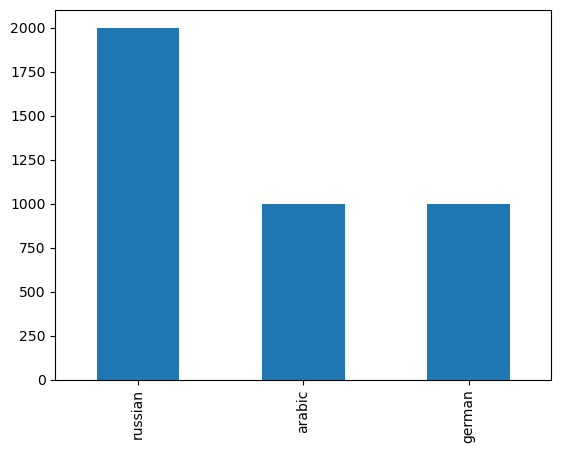

In [24]:
multi_val_df["source"].value_counts().plot.bar()
plt.show()

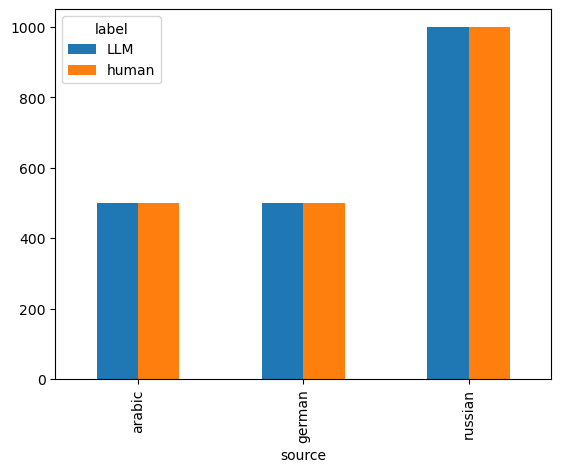

In [25]:
multi_val_df.groupby(['source', 'label']).size().unstack(fill_value=0).plot.bar()
plt.show()